<a href="https://colab.research.google.com/github/claitonp/tech-challenge/blob/main/tech_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tech Challenge - Fase 1 (Grupo 40)



**FIAP - Pos Tech - IA para DEVs**

**Professora**: Ana Raquel

**Alunos:**

- Claiton Aparecido Pereira  - RM355839
- Eduardo Pedrosa Cajueiro   - RM355819
- Hiomone Oliveira Rodrigues -
- Leonardo Lima Ferreira     - RM355721
- Thiago Silva Cerqueira     - RM355830

# Itens abordados:

*  1 - Exploração inicial dos dados
*  2 - Pré-processamento dos dados
*  3 - Exploração dos dados após ajustes
*  4 - Modelos de regressão
*  5 - Separando as bases em treino e teste
*  6 - Linear Regression
*  7 - DecisionTreeRegressor
*  8 - RandomForestRegressor
*  9 - GradientBoostingRegressor
* 10 - Executando todos os modelos
* 11 - Verificação de overfitting e hiperparâmetros
* 12 - Resultados e conclusões

# Fluxograma


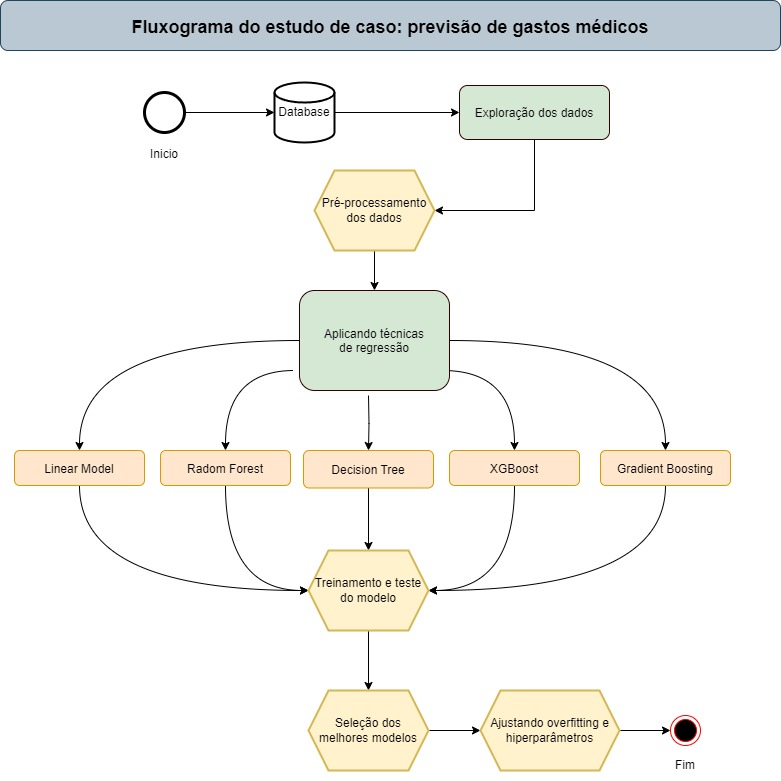

# Imports necessários para execução

In [2]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

from scipy import stats

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import roc_curve, roc_auc_score, classification_report

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso

from sklearn.model_selection import GridSearchCV

from xgboost import XGBRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

#from imblearn.over_sampling import SMOTE
# ! pip install --upgrade imbalanced-learn

import warnings
warnings.filterwarnings("ignore")



**Constantes utilizadas**

In [3]:
# Constantes

COL_AGE      = 'age'
COL_SEX      = 'sex'
COL_SMOKER   = 'smoker'
COL_REGION   = 'region'
COL_CHILDREN = 'children'
COL_BMI      = 'bmi'
COL_BMI_TYPES= 'bmi-types'  # categorizacao de bmi

COL_CHARGES  = 'charges' # target

DATABASE_NAME = 'medical_insurance.csv'

LINEAR_REGRESSION_NAME           = "linear_regression"
DECISION_TREE_REGRESSOR_NAME     = "decision_tree_regressor"
RANDOM_FOREST_REGRESSOR_NAME     = "random_forest_regressor"
GRADIENT_BOOSTING_REGRESSOR_NAME = "gradient_boosting_regressor"
XGB_REGRESSOR_NAME               = "xgb_regressor"
LASSO_NAME                       = "lasso"
RIDGE_NAME                       = "ridge"

models = [LINEAR_REGRESSION_NAME,
          DECISION_TREE_REGRESSOR_NAME,
          RANDOM_FOREST_REGRESSOR_NAME,
          GRADIENT_BOOSTING_REGRESSOR_NAME,
          XGB_REGRESSOR_NAME,
          LASSO_NAME,
          RIDGE_NAME]

ratings = pd.DataFrame();

# Functions

- **Funcions - Pré-processamento dos dados**

In [4]:
# carrega a base de dados
def initialize_database():
  dados = pd.read_csv(DATABASE_NAME)
  #dados = pd.read_csv("medical_insurance.csv") # base do kaggle
  print("base de dados inicializada...")
  return dados


# lista os registros duplicados
def list_duplicated(dados):
  duplicados = dados.duplicated()
  numero_duplicados = duplicados.sum()
  print(f"Número de registros duplicados: {numero_duplicados}")

  linhas_duplicadas = dados[duplicados]
  #print(linhas_duplicadas)


# remove os registros duplicados
def remove_duplicated(dados):
  list_duplicated(dados);
  print(dados.shape)
  print("removendo dados duplicados...")
  # Removendo duplicados (por padrão, mantém a primeira linha)
  dados = dados.drop_duplicates()
  # reindexando a base de dados
  dados = dados.reset_index(drop=True)
  print(dados.shape)
  return dados

# Remoção de valores de gastos (charges) discrepantes, outliers
def remove_outliers(dados):
  print("removendo outliers...")

  # estrategia 1 - excluindo registros que estão acima de 3 desvios padrão da média
  dados = dados[np.abs(stats.zscore(dados[COL_CHARGES])) <3]

  # estrategia 2 - excluido registros acima de um percentual
  #q3 = np.percentile(dados['charges'], 85)
  #dados = dados[dados['charges'] <= q3]

  dados = dados.reset_index(drop=True)

  print(dados.shape)

  return dados


# codifica as colunas categóricas em valores númericos para facilitar o uso em modelos de aprendizado de máquina.
def encoded_labels(dados):
  colunas=['sex','smoker','region']
  print("encoded_labels:", colunas )

  label_encoder = LabelEncoder()
  for col in colunas:
    dados[col] = label_encoder.fit_transform(dados[col])
  return dados

def onehot_enconding(dados):
    colunas = ['sex', 'smoker', 'region']
    print("onehot_enconding:", colunas)

    # Use pd.get_dummies para one-hot encoding
    dados = pd.get_dummies(dados, columns=colunas)

    for col in dados.columns:
      if any(sub in col for sub in colunas):
        dados[col] = dados[col].astype(int)
    return dados

# cria uma nova coluna 'bmi-types' de acordo com o intervalos definidos de classificação BMI
def category_bmi(dados):
  print("categorizando a coluna bmi -> bmi-types")
  #dados.loc[:,"bmi-types"] = pd.cut(dados["bmi"],
  dados[COL_BMI_TYPES] = pd.cut(dados[COL_BMI],
                        bins=[0, 18.5, 24.9, 29.9, 34.9, 39.9, np.inf],
                        labels=[1, 2, 3, 4, 5, 6]).cat.codes

#  if COL_BMI_TYPES != COL_BMI:
#    dados = dados.drop(columns = [COL_BMI]).copy()

  #dados.reset_index(drop=True)
  return dados


# cria uma nova coluna 'age-types' de acordo com as faixas etárias da ANS
#def category_age(dados):
#  print("categorizando a coluna age -> age-types")
#  dados[COL_AGE_TYPES] = pd.cut(dados[COL_AGE],
#                        bins=[0, 18, 23, 28, 33, 38, 43, 48, 53, 59, np.inf],
#                        labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]).cat.codes
##  dados = dados.drop(columns = [COL_AGE]).copy()
  return dados


# insere dados na base de dados até n
def run_upsampling(dados):
  print("run_upsampling")
  dados = dados.sample(n=5000, replace=True, random_state=42, ignore_index=True)
  print(dados.shape)
  return dados


def process_database(dados, duplicated, outliers, upsample):
  if duplicated:
    dados = remove_duplicated(dados)
  if outliers:
    dados = remove_outliers(dados)
  if upsample:
     dados = run_upsampling(dados)
  dados = encoded_labels(dados)
  #dados = onehot_enconding(dados)
  dados = category_bmi(dados)
 # dados = category_age(dados)
  return dados




- **Funcions - Split dados train e test**

In [5]:
# definindo as colunas X para predição e Y (target)
def define_x_y():
  y = dados[COL_CHARGES]
  X = dados[[COL_AGE, COL_SEX, COL_SMOKER, COL_REGION, COL_CHILDREN, COL_BMI, COL_BMI_TYPES]]
#  X = dados[[COL_AGE, COL_SMOKER,COL_BMI, COL_BMI_TYPES]]
  return X, y

# definindo as colunas X para predição e Y (target)
#def define_x_y_age_types():
#  y = dados[COL_CHARGES]
#  X = dados[[COL_AGE_TYPES, COL_SEX, COL_SMOKER, COL_REGION, COL_CHILDREN, COL_BMI_TYPES]]
#  return X, y



# Esta função divide um conjunto de dados em conjuntos de treino e teste, preservando a distribuição de classes na categoria
def process_train_test(X, y, shuffle=True, standard_scaler=False, min_max_scaler=False):
    print(f"ShuffleSplit bmi-types: {shuffle} StandardScaler: {standard_scaler} MinMaxScaler: {min_max_scaler}")
    if shuffle:
      split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)  # este embaralha os dados antes da divisão
#      for train_index, test_index in split.split(X, X[['age-types', 'bmi-types']]):
#      for train_index, test_index in split.split(X[[COL_AGE, COL_SMOKER, COL_BMI]], X[COL_BMI_TYPES]):
      for train_index, test_index in split.split(X[[COL_AGE, COL_SEX, COL_SMOKER, COL_REGION, COL_CHILDREN, COL_BMI]], X[COL_BMI_TYPES]):
          shuffe_train = dados.loc[train_index]
          shuffe_test = dados.loc[test_index]


      #print("% base de treino -------------------")
      #print(shuffe_train[COL_BMI_TYPES].value_counts() / len(shuffe_train))

      #print("% base de teste ---------------------")
      #print(shuffe_test[COL_BMI_TYPES].value_counts() / len(shuffe_test))

      if COL_BMI_TYPES != COL_BMI:
        print("removendo coluna bmi-types do train e test")
        for set_ in (shuffe_train, shuffe_test):
          set_.drop(COL_BMI_TYPES, axis=1, inplace=True)

      X_train = shuffe_train.copy()
      y_train = X_train[COL_CHARGES].copy()

      X_train = X_train.drop(columns=[COL_CHARGES], axis=1)

      X_test = shuffe_test.copy()
      y_test = X_test[COL_CHARGES].copy()

      X_test = X_test.drop(columns=[COL_CHARGES], axis=1)
    else:
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if standard_scaler:
      scaler = StandardScaler()
      X_train = scaler.fit_transform(X_train)
      X_test = scaler.transform(X_test)

    if min_max_scaler:
      scaler = MinMaxScaler()
      X_train = scaler.fit_transform(X_train)
      X_test = scaler.transform(X_test)

    return X_train, y_train, X_test, y_test


def calculate_mape(labels, predictions):
    errors = np.abs(labels - predictions)
    relative_errors = errors / np.abs(labels)
    mape = np.mean(relative_errors) * 100
    return mape


- **Funcions - modelos de regressão**

In [6]:

# cria, treina e utiliza um modelo de regressão linear para prever valores em um conjunto de dados de teste.
def linear_regression():
  model = LinearRegression()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  return model, y_pred


# cria, treina e utiliza um modelo de Regressão por Árvore de Decisão para prever valores em um conjunto de dados de teste.
def decision_tree_regressor():
  model = DecisionTreeRegressor(random_state=42)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  return model, y_pred


#  cria, treina e utiliza um modelo de Regressão Random Forest para prever valores em um conjunto de dados de teste.
def random_forest_regressor():
  #model = RandomForestRegressor(random_state=42)
  model = RandomForestRegressor(max_depth = 5, max_features = 'auto', n_estimators = 180, min_samples_leaf = 10, min_samples_split =5, random_state = 42)
  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)
  return model, y_pred


#  cria, treina e utiliza um modelo de Regressão ???
def gradient_boosting_regressor():
  #model = GradientBoostingRegressor(n_estimators=90, random_state=42,  learning_rate = 0.04, subsample = 0.06)  #  max_depth=3
  model = GradientBoostingRegressor(n_estimators=88, random_state=42, max_depth=2, max_features= 'auto', min_samples_leaf=7, min_samples_split=7, learning_rate = 0.07, subsample = 0.3)
  #model = GradientBoostingRegressor(random_state=42)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  return model, y_pred

def xgb_regressor():
  model = XGBRegressor(n_estimators=100, random_state=42) # max_depth=3, gamma=0
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  return model, y_pred

def lasso():
  model = Lasso(alpha=1.0, random_state=42) # max_depth=3, gamma=0
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  return model, y_pred


def ridge():
  model = Ridge(alpha=1.0, random_state=42) # max_depth=3, gamma=0
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  return model, y_pred


def model_run(engine, ratings):
  model = None
  y_pred = None
  if (engine == "decision_tree_regressor"):
    model, y_pred = decision_tree_regressor()
  elif (engine == "random_forest_regressor"):
    model, y_pred = random_forest_regressor()
  elif (engine == "linear_regression"):
    model, y_pred = linear_regression()
  elif (engine == "gradient_boosting_regressor"):
    model, y_pred = gradient_boosting_regressor()
  elif (engine == "xgb_regressor"):
    model, y_pred = xgb_regressor()
  elif (engine == "lasso"):
    model, y_pred = lasso()
  elif (engine == "ridge"):
    model, y_pred = ridge()
  else:
    raise ValueError(f"Modelo {engine} não reconhecido.")
  evaluate = model_evaluate(model, X_train, y_train, X_test, y_test, y_pred)
  ratings = add_rating(evaluate, ratings)
  return model, y_pred, ratings


- **Funcions - validação do modelo**

In [7]:
def calculate_mape(labels, predictions):
    errors = np.abs(labels - predictions)
    relative_errors = errors / np.abs(labels)
    mape = np.mean(relative_errors) * 100
    return mape


# Esta função avalia o desempenho de um modelo de regressão e retorna um dicionário com métricas de desempenho.
def model_evaluate(model, X_train, y_train, X_test, y_test, y_pred):
  #print("Avaliando o desempenho do modelo: ", model.__class__.__name__)
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  mape = calculate_mape(y_test, y_pred)
  rmse = np.sqrt(mse);

#  p_values(model, X_train, y_train)

#  print("mse - Mean Squared Error :", mse)
#  print("mae - Mean Absolute Error:", mae)
  print(f"Avaliando o desempenho do modelo: {model.__class__.__name__} - r2-score: {r2}")

#  print("O score nos dá uma visão da precisão média da floresta aleatória nos dados")
#  print("score train: ", model.score(X_train, y_train))
#  print("score test : ", model.score(X_test, y_test))


  #print(f"socre train: {model.score(X_train, y_train)} score test: {model.score(X_test, y_test)}")

  score_std, score_mean = cross_validate(model)

  return {'model': model.__class__.__name__,
          'remove_duplicated': removed_duplicated,
          'remove_outliers': removed_outliers,
          'upsampling': upsampling,
          'shuffle_bmi': shuffle_split,
          'std_scaler': standard_scaler,
          'min_max_scaler': min_max_scaler,
          'k-fold std': score_std,
          'k-fold mean': score_mean,
          'mae': mae.round(2),
          'mse': mse.round(2),
          'rmse': rmse.round(2),
          'mape': mape.round(2),
          'r2-score': r2.round(4)
        }


# realiza validação cruzada k-fold para avaliar o desempenho de um modelo de regressão e retorna o desvio padrão e a média dos scores de R².
def cross_validate(model, k=10):
  #print("Validação cruzada:", k, model.__class__.__name__,)

  # Realize a validação cruzada e armazene os resultados em 'scores'
  scores = cross_val_score(model, X, y, cv=KFold(n_splits=k, shuffle=True, random_state=42))

#  print("K-Fold (R^2) Scores: {0}".format(scores))
#  print("Desvio padrão do R²:", scores.std())
  #print("Média do R²:", scores.mean())
  return scores.std(), scores.mean()


def add_rating(evaluation, ratings):
  df = pd.DataFrame([evaluation])
  ratings = pd.concat([ratings, df], ignore_index=True)
  return ratings


def plot_learning_curves(model, X_train, X_test, y_train, y_test):
    train_errors, test_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_test_predict = model.predict(X_test)

        mse_train = mean_squared_error(y_train[:m], y_train_predict)
        mse_test = mean_squared_error(y_test, y_test_predict)
        #print(f"mse {m} train: {np.sqrt(mse_train)} test: {np.sqrt(mse_test)} dif: {np.sqrt(mse_test) - np.sqrt(mse_train)}")

        train_errors.append(mse_train)
        test_errors.append(mse_test)

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(test_errors), "b-", linewidth=3, label="test")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Train size", fontsize=14)
    plt.ylabel("rmse", fontsize=14)


def plt_real_previsto(y_test, y_pred, model):
  plt.scatter(y_test, y_pred)
  plt.xlabel('Gasto real')
  plt.ylabel('Gasto previsto')
  plt.title('Real vs previsto - ' + model.__class__.__name__)
  ideal_values = np.linspace(min(y_test), max(y_test))
  plt.plot(ideal_values, ideal_values, color='red', label='Previsto')
  plt.legend()
  plt.show()

def plt_real_previso_por(X_test, y_test, y_pred, feature):
  plt.scatter(X_test[feature], y_test, label='Real')
  plt.scatter(X_test[feature], y_pred, label='Previsto', color='red')
  plt.xlabel(feature)
  plt.ylabel('Valores Gasto')
  plt.title('Previsões do modelo por: ' + feature)
  plt.legend()
  plt.show()

# 1 - Exploração inicial dos dados

**- Base de dados**

- A base de dados foi obtida do kaggle.com https://www.kaggle.com/datasets/rahulvyasm/medical-insurance-cost-prediction?resource=download :


- **2772** registros
- Não há registros vazios ou nulos
- Há **1435** linhas duplicadas
- Após a remoção das linhas duplicadas, a base de dados ficou **1337** linhas


**- Atributos da base de dados:**

- **age**: idade
- **sex**: sexo
- **bmi**: indice de massa corporal
- **children**: número de filhos
- **smoker**: fumante
- **region**: região
- **charges**: gastos com saúde

- Inicializando a base de dados

In [8]:
dados = pd.read_csv(DATABASE_NAME)

In [ ]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB


In [ ]:
dados.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


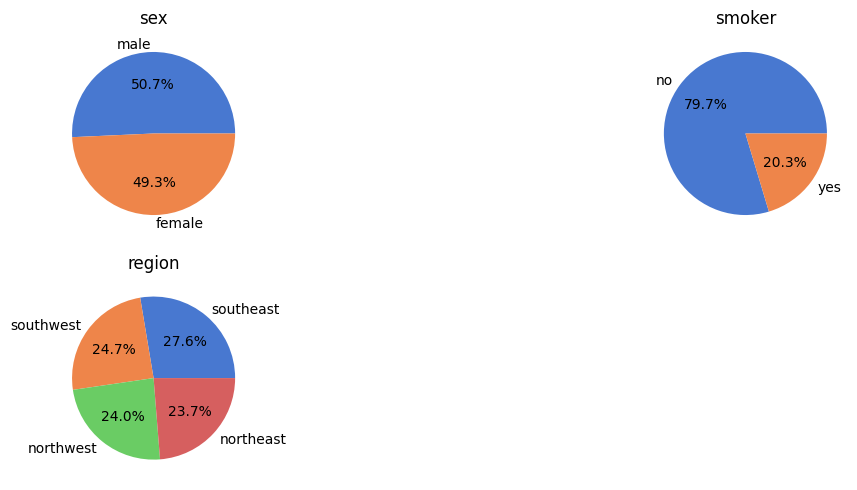

In [9]:
plt.figure(figsize=(14,9))
for i,col in enumerate([COL_SEX, COL_SMOKER, COL_REGION]):
    plt.subplot(3,2,i+1)
    x=dados[col].value_counts().reset_index()
    plt.title(col)
    plt.pie(x=x['count'],labels=x[col],autopct="%0.1f%%",colors=sns.color_palette('muted'))

In [ ]:
dados.describe().T

,count,mean,std,min,25%,50%,75%,max
age,2772.0,39.109668,14.081459,18.0000,26.000,39.00000,51.0000,64.00000
bmi,2772.0,30.701349,6.129449,15.9600,26.220,30.44750,34.7700,53.13000
children,2772.0,1.101732,1.214806,0.0000,0.000,1.00000,2.0000,5.00000
charges,2772.0,13261.369959,12151.768945,1121.8739,4687.797,9333.01435,16577.7795,63770.42801


In [ ]:
dados.groupby(COL_SMOKER).describe()

age                                                         bmi  \
         count       mean        std   min   25%   50%   75%   max   count   
smoker                                                                       
no      2208.0  39.275362  14.114949  18.0  26.0  39.0  52.0  64.0  2208.0   
yes      564.0  38.460993  13.943055  18.0  27.0  37.5  49.0  64.0   564.0   

                   ... children      charges                              \
             mean  ...      75%  max   count          mean           std   
smoker             ...                                                     
no      30.665765  ...      2.0  5.0  2208.0   8417.874411   6015.568209   
yes     30.840656  ...      2.0  5.0   564.0  32223.139764  11521.258969   

                                                                         
               min           25%         50%           75%          max  
smoker                                                                   
no       1121.8739   3953.906862   7341.4160  11354.085925  36910.60803  
yes     12829.4551  20984.093600  34725.8811  41097.161750  63770.42801  

[2 rows x 32 columns]

<Axes: xlabel='children', ylabel='Count'>

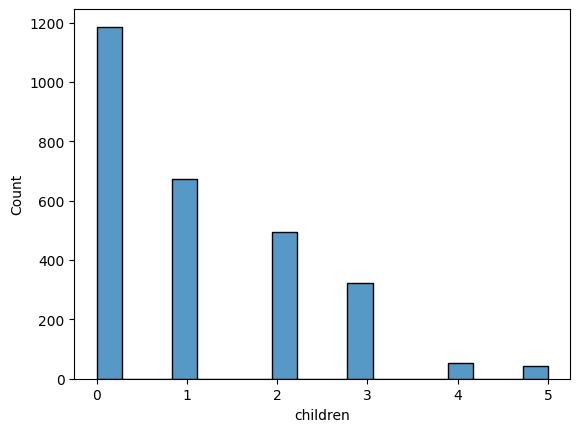

In [ ]:
sb.histplot(data=dados, x=COL_CHILDREN)

<Axes: xlabel='bmi', ylabel='Count'>

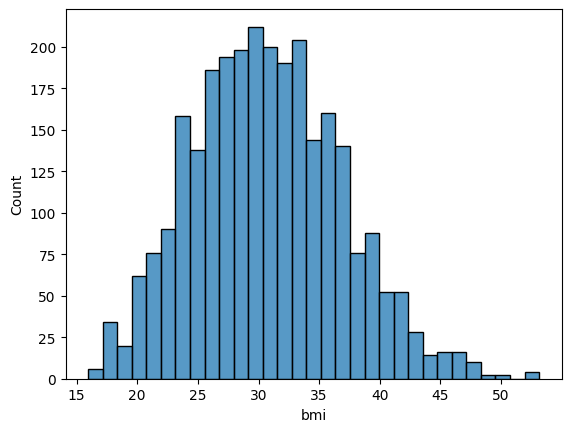

In [ ]:
sb.histplot(data=dados, x=COL_BMI)

<Axes: ylabel='charges'>

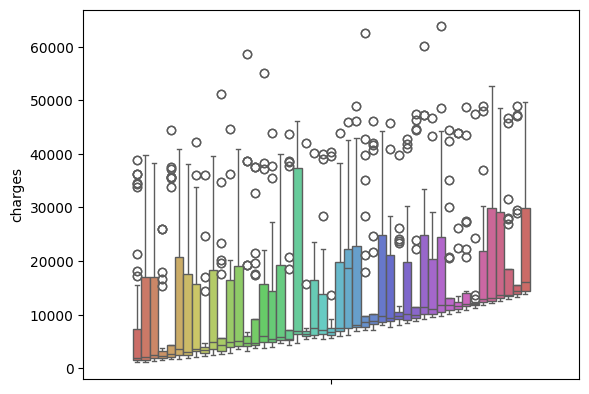

In [ ]:
sb.boxplot(hue=COL_AGE, y=COL_CHARGES, data=dados, palette='hls', legend=False)

**Obs:** Pode ser observado nesse gráfico, a relação da idade e dos gastos, que com o avanço da idade os gastos vão aumentando....

<Axes: xlabel='smoker', ylabel='charges'>

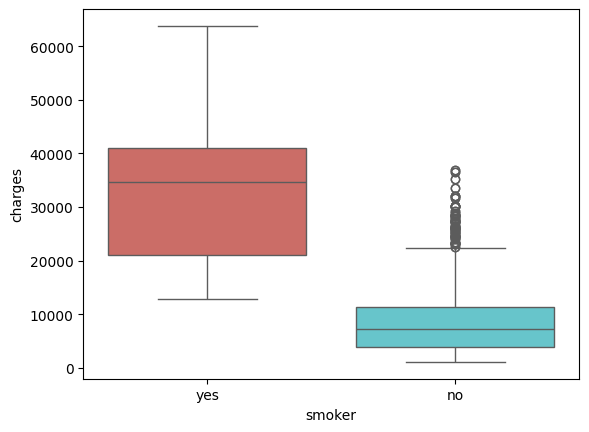

In [ ]:
sb.boxplot(x=COL_SMOKER, y=COL_CHARGES, hue=COL_SMOKER, data=dados, palette='hls', legend=False)

**Obs:** Nesse gráfico pode ser observado que o fumante tem um gasto maior, em relação ao não fumante.

<Axes: xlabel='sex', ylabel='charges'>

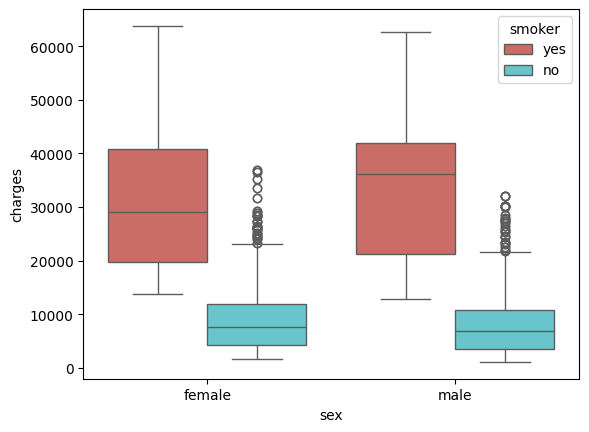

In [ ]:

sb.boxplot(x=COL_SEX, y=COL_CHARGES, hue=COL_SMOKER, data=dados, palette='hls', legend=True)

<Axes: xlabel='charges'>

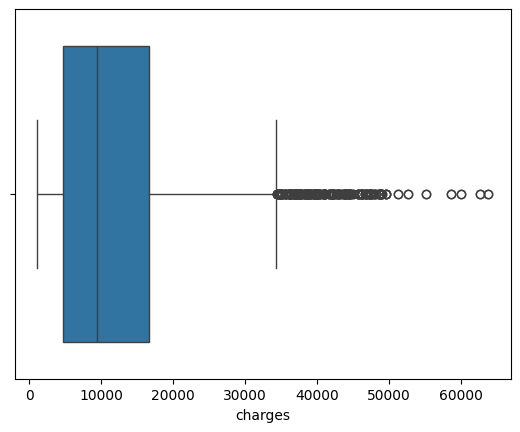

In [ ]:
sb.boxplot(x=dados[COL_CHARGES])

<Axes: xlabel='bmi'>

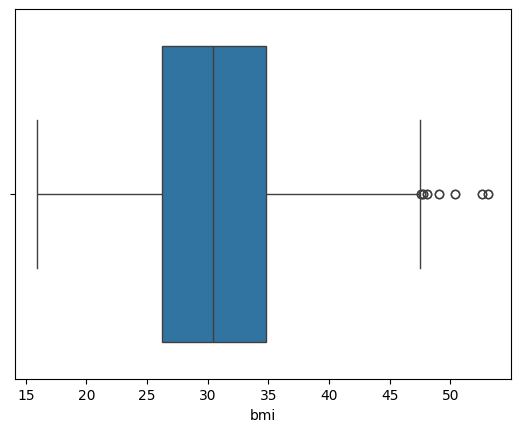

In [ ]:
sb.boxplot(x=dados[COL_BMI])

Text(0.5, 1.0, 'Combinação idade, fumante e gastos')

<Figure size 2000x1200 with 0 Axes>

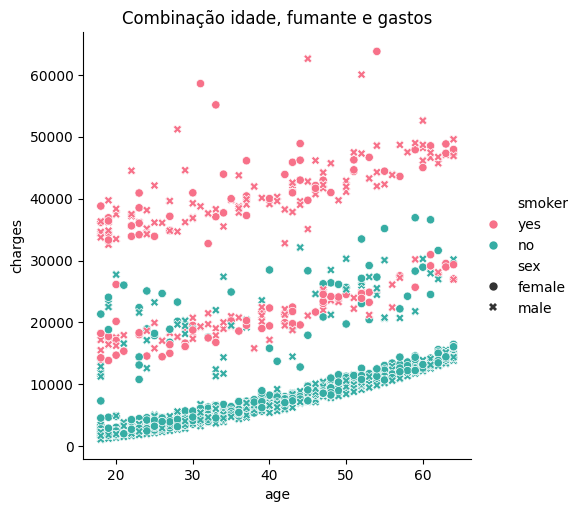

In [ ]:
plt.figure(figsize=(20, 12))
sns.relplot(x='age', y='charges', hue='smoker', style= 'sex', data=dados, palette='husl')
plt.title('Combinação idade, fumante e gastos')

**Obs:** Aqui neste gráfico pode perceber que fumantes tem mais gastos com o plano de saude e com o avanco da idade o gasto vai aumentando.


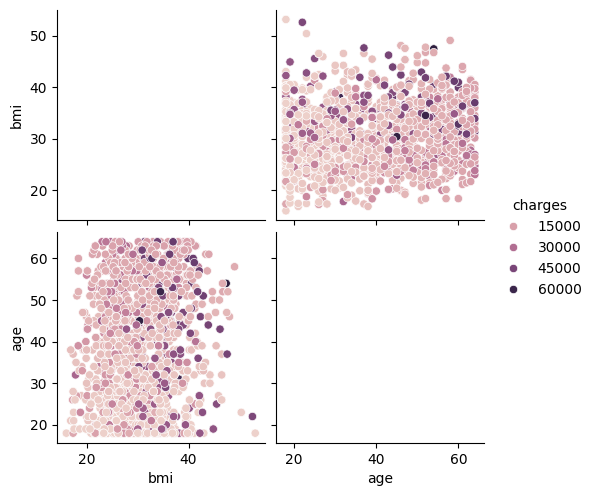

In [ ]:
sb.pairplot(dados,vars=[COL_BMI, COL_AGE],hue=COL_CHARGES)

**Obs:** Nesses gráficos, pode ser observar que quanto maior o bmi (indice de massa corportal) maior o gasto com o plano de saúde, o mesmo com  avanço da idade.

#2 - Pré-processamento os dados

Foram testadas as seguintes técnicas:

- Eliminação  de registros duplicados;
- Removendo outliers;
- Label enconder: sex, region, smoker;
- Categorizando 'bmi';
- Categorizando 'age' (não foi utilizada);
- Upsampling;
- StandardScaler.

**2.1 - Eliminação de Registros duplicados**


* Listando os registros duplicados da base de dados




In [14]:
list_duplicated(dados)

Número de registros duplicados: 1435


- removendo os registros duplicados

In [15]:

dados = remove_duplicated(dados)


Número de registros duplicados: 1435
(2772, 7)
removendo dados duplicados...
(1337, 7)


**2.2 - Removendo outliers**

Remoção de valores de gastos (charges) discrepantes, de registros que estão acima de 3 desvios padrão da média

In [16]:
dados = remove_outliers(dados)

removendo outliers...
(1330, 7)


remoção de valores discrepantes com base nas pontuações **z** em um conjunto de dados​. Quando aplicamos a regra dos **3 desvios padrão**, estamos considerando que mais de **99%** dos dados estão dentro deste intervalo em uma distribuição normal.
Assim, os valores que estão além de 3 desvios padrão da média são considerados incomuns ou **outliers**.

**OBS:**  **7** registros excluidos, considerados outliers

**2.3 - LabelEncoder**

Três colunas são categóricas: **sex, smoker e region**. Para o nosso modelo de aprendizagem de máquina teremos que transforma-las essas colunas em númericas. Iremos utilizar a técnica de LabelEnconder

Vamos utilizar **label enconder** para tratar variáveis categóricas: **sex, smoker e region**

In [17]:
print(dados.head())

dados = encoded_labels(dados)

print(dados.head())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
encoded_labels: ['sex', 'smoker', 'region']
   age  sex     bmi  children  smoker  region      charges
0   19    0  27.900         0       1       3  16884.92400
1   18    1  33.770         1       0       2   1725.55230
2   28    1  33.000         3       0       2   4449.46200
3   33    1  22.705         0       0       1  21984.47061
4   32    1  28.880         0       0       1   3866.85520


**2.4 - Categorizando BMI**

**`O índice de massa corporal ( IMC )`** é um valor derivado da massa ( peso ) e altura de uma pessoa. O IMC é definido como a massa corporal dividida pelo quadrado da altura corporal e é expresso em unidades de kg/m 2




IMC, categorias básicas Categoria	IMC (kg/m 2 )
- Abaixo do peso (magreza severa):	< 16,0
- Abaixo do peso (magreza moderada):	16,0 – 16,9
- Abaixo do peso (magreza leve):	17,0 – 18,4
- Intervalo normal:	18,5 – 24,9
- Excesso de peso (pré-obeso):	25,0 – 29,9
- Obeso (Classe I):	30,0 – 34,9
- Obeso (Classe II):	35,0 – 39,9
- Obeso (Classe III):	≥ 40,0

In [18]:
dados = category_bmi(dados)
#dados[[COL_BMI, COL_BMI_TYPES]]


categorizando a coluna bmi -> bmi-types


**2.5 - Categorizando Age**

**Categorizando idades por faixas etárias**

Faixas definidas pela  ANS - Agência Nacional de Saúde Suplementar:

- 0 a 18 anos
- 19 a 23 anos
- 24 a 28 anos
- 29 a 33 anos
- 34 a 38 anos
- 39 a 43 anos
- 44 a 48 anos
- 49 a 53 anos
- 54 a 58 anos
- 59 anos ou mais

In [ ]:
#dados = category_age(dados)
#dados[COL_AGE_TYPES]

**2.6 - Upsampling**

**Upsampling** é uma técnica de manipulação de dados usada para resolver o desequilíbrio de classes em conjuntos de dados, mas é importante considerar suas limitações, como **Overfitting**

In [ ]:
#print(dados.shape)

#dados = run_upsampling(dados)

#upsampling = True
#print(dados.shape)

**2.7 - StandardScaler**

**Obs:** Não há melhoras no modelo, usando StandardScaler

In [ ]:
#X, y = define_x_y()
#standard_scaler = True
#shuffle_split = False
#X_train, y_train, X_test, y_test = process_train_test(X, y, shuffle_split, standard_scaler)

# 3 - Exploração de dados após ajustes

In [ ]:
dados.head()


,age,sex,bmi,children,smoker,region,charges,bmi-types
0,19,0,27.900,0,1,3,16884.92400,2
1,18,1,33.770,1,0,2,1725.55230,3
2,28,1,33.000,3,0,2,4449.46200,3
3,33,1,22.705,0,0,1,21984.47061,1
4,32,1,28.880,0,0,1,3866.85520,2


In [ ]:

print(dados[COL_BMI].skew())
print(dados[COL_AGE].skew())

0.27994423304168925
0.061638859731918856


A função **skew()** do Pandas é utilizada para calcular a assimetria (ou coeficiente de inclinação) de uma distribuição de dados em uma série.

Os dados nas colunas de idade e IMC seguem aproximadamente uma distribuição Normal, o que é um bom ponto em relação ao aprendizado do modelo.

- Se a assimetria é p**róxima de 0**, isso indica que a distribuição é aproximadamente simétrica.

- Se a assimetria é **positiva**, isso indica que a cauda direita da distribuição é mais longa ou mais gorda do que a esquerda. Os dados têm uma cauda longa à direita.

- Se a assimetria é **negativa**, isso indica que a cauda esquerda da distribuição é mais longa ou mais gorda do que a direita. Os dados têm uma cauda longa à esquerda.


In [ ]:
dados.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1330.0,39.200752,14.052396,18.0000,26.250000,39.000000,51.000000,64.0000
sex,1330.0,0.504511,0.500168,0.0000,0.000000,1.000000,1.000000,1.0000
bmi,1330.0,30.633049,6.091072,15.9600,26.220000,30.302500,34.600000,53.1300
children,1330.0,1.097744,1.206108,0.0000,0.000000,1.000000,2.000000,5.0000
smoker,1330.0,0.200752,0.400713,0.0000,0.000000,0.000000,0.000000,1.0000
region,1330.0,1.515038,1.105496,0.0000,1.000000,2.000000,2.000000,3.0000
charges,1330.0,13045.345009,11699.581595,1121.8739,4724.369462,9303.297725,16389.832412,49577.6624
bmi-types,1330.0,2.640602,1.186901,0.0000,2.000000,3.000000,3.000000,5.0000


**- Distribuição percentual dos gastos médios de CHARGES por BMI_TYPES**

In [ ]:
mean = dados.groupby(COL_BMI_TYPES)[COL_CHARGES].mean().round(2)
print("Média de CHARGES por BMI_TYPES:")
print(mean)

# Calcula a distribuição percentual dos gastos médios em relação ao total
percent_total = ((mean / mean.sum()) * 100).round(2)
print("\nDistribuição percentual dos gastos médios de CHARGES por BMI_TYPES (em relação ao total):")
print(percent_total)

Média de CHARGES por BMI_TYPES:
bmi-types
0     8657.62
1    10404.90
2    11006.81
3    13912.34
4    16737.94
5    16155.62
Name: charges, dtype: float64

Distribuição percentual dos gastos médios de CHARGES por BMI_TYPES (em relação ao total):
bmi-types
0    11.26
1    13.53
2    14.32
3    18.10
4    21.77
5    21.02
Name: charges, dtype: float64


In [ ]:
# contagem de ocorrências de REGION e BMI_TYPES
contingency_table = pd.crosstab(dados[COL_REGION], dados[COL_BMI_TYPES])

# Normaliza a tabela de contingência para obter as proporções (percentuais)
percent_table = pd.crosstab(dados[COL_REGION], dados[COL_BMI_TYPES], normalize='all') * 100

print("Contagem de combinações de REGION e BMI_TYPES:")
print(contingency_table)

print("\nDistribuição percentual de combinações de REGION e BMI_TYPES (em relação ao total):")
print(percent_table)


Contagem de combinações de REGION e BMI_TYPES:
bmi-types   0   1    2    3   4   5
region                             
0          10  72   98   89  38  16
1           7  62  106  104  35   8
2           0  40   75   99  93  55
3           4  47  101  101  57  13

Distribuição percentual de combinações de REGION e BMI_TYPES (em relação ao total):
bmi-types         0         1         2         3         4         5
region                                                               
0          0.751880  5.413534  7.368421  6.691729  2.857143  1.203008
1          0.526316  4.661654  7.969925  7.819549  2.631579  0.601504
2          0.000000  3.007519  5.639098  7.443609  6.992481  4.135338
3          0.300752  3.533835  7.593985  7.593985  4.285714  0.977444


In [ ]:
table = pd.crosstab(dados[COL_SMOKER], dados[COL_BMI_TYPES], values=dados[COL_CHARGES], aggfunc='mean')

# Calcula a distribuição percentual dos gastos médios em relação ao total
percent_table_total = ((table / table.sum().sum()) * 100).round(2)

count_table = pd.crosstab(dados[COL_SMOKER], dados[COL_BMI_TYPES])

print("Quantitativo de fumantes e não fumanates e sua categoria BMI (em relação ao total):")
print(count_table)

# Calcula a distribuição percentual dos gastos médios em relação a cada região
percent_table_agg = (table.div(table.sum(axis=1), axis=0) * 100).round(2)

print("Distribuição percentual dos gastos médios de fumantes e não fumanates e sua categoria BMI (em relação ao total):")
print(percent_table_total)

#print("\nDistribuição percentual dos gastos médios de CHARGES (em relação a cada bmi_types e smoker):")
#print(percent_table_agg)

Quantitativo de fumantes e não fumanates e sua categoria BMI (em relação ao total):
bmi-types   0    1    2    3    4   5
smoker                               
0          16  171  308  322  174  72
1           5   50   72   71   49  20
Distribuição percentual dos gastos médios de fumantes e não fumanates e sua categoria BMI (em relação ao total):
bmi-types     0     1     2      3      4      5
smoker                                          
0          2.34  3.26  3.57   3.64   4.11   3.53
1          8.04  8.52  9.57  16.41  17.96  19.04


**Obs.:** nesta amostra de dados, os fumantes representa 20% do total. E pode ser observado que os fumantes gastam de 3 a 4 vez mais do que o não fumante.

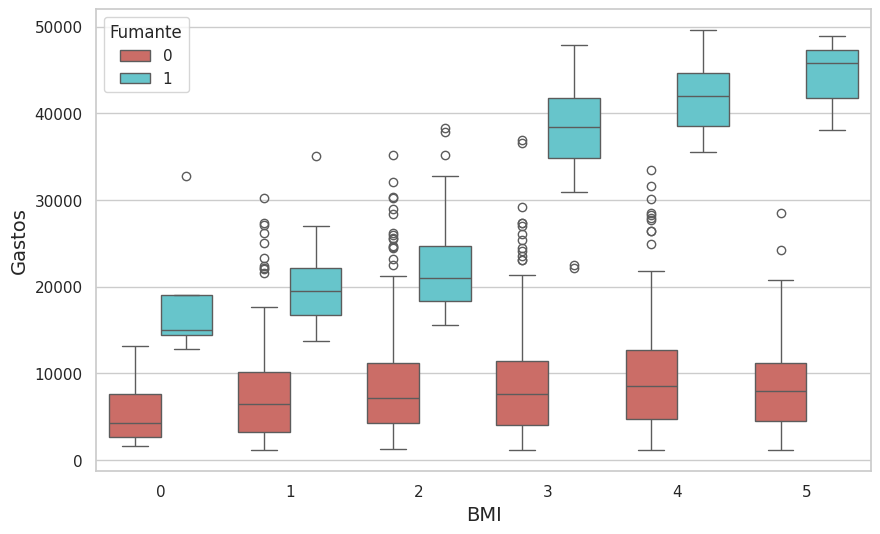

In [ ]:
plt.figure(figsize=(10, 6))
sb.boxplot(x=COL_BMI_TYPES, y=COL_CHARGES, hue=COL_SMOKER, data=dados, palette='hls', legend=True)

plt.xlabel('BMI', fontsize=14)
plt.ylabel('Gastos', fontsize=14)
plt.legend(title='Fumante')
plt.show()

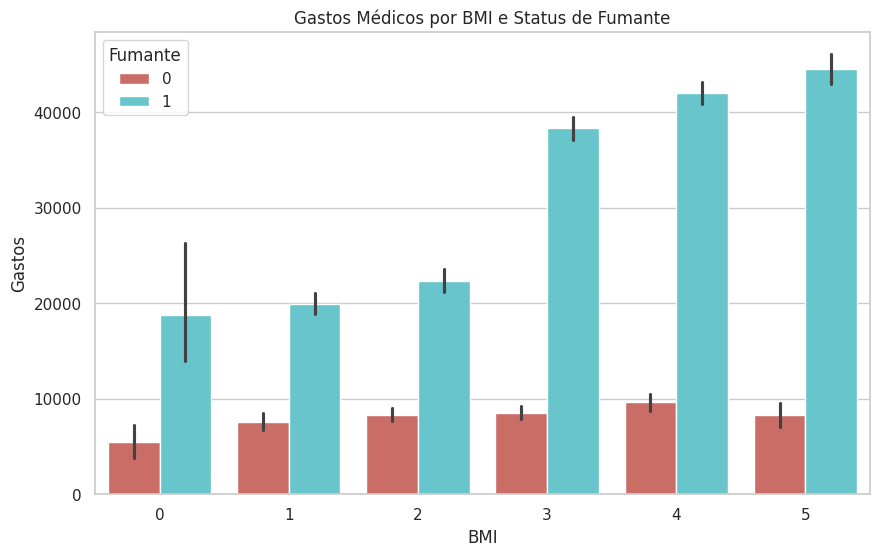

In [ ]:
plt.figure(figsize=(10, 6))
sb.barplot(x=COL_BMI_TYPES, y=COL_CHARGES, hue=COL_SMOKER, data=dados, palette='hls')

plt.xlabel('BMI')
plt.ylabel('Gastos')
plt.title('Gastos Médicos por BMI e Status de Fumante')
plt.legend(title='Fumante')

plt.show()

**Obs.:** nesta amostra de dados, os fumantes representa 20% do total. E pode ser observado que os fumantes gastam de 3 a 4 vez mais do que o não fumante.

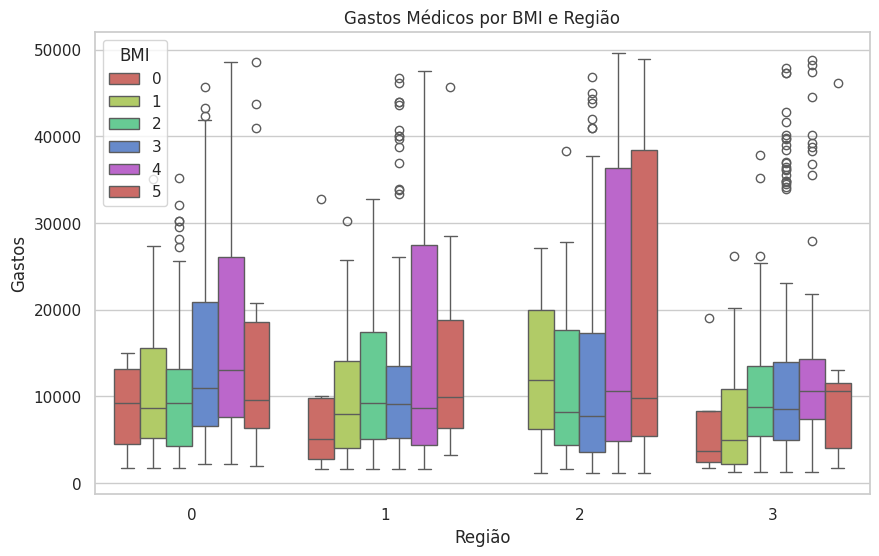

In [ ]:
plt.figure(figsize=(10, 6))
sb.boxplot(x=COL_REGION, y=COL_CHARGES, hue=COL_BMI_TYPES, data=dados, palette='hls', legend=True)

plt.xlabel('Região')
plt.ylabel('Gastos')
plt.title('Gastos Médicos por BMI e Região')
plt.legend(title='BMI')

plt.show()

**Obs**.:  A região 2 (southeast), bmi 5 tem um alto valores de gastos demostrado do gráfico acima.

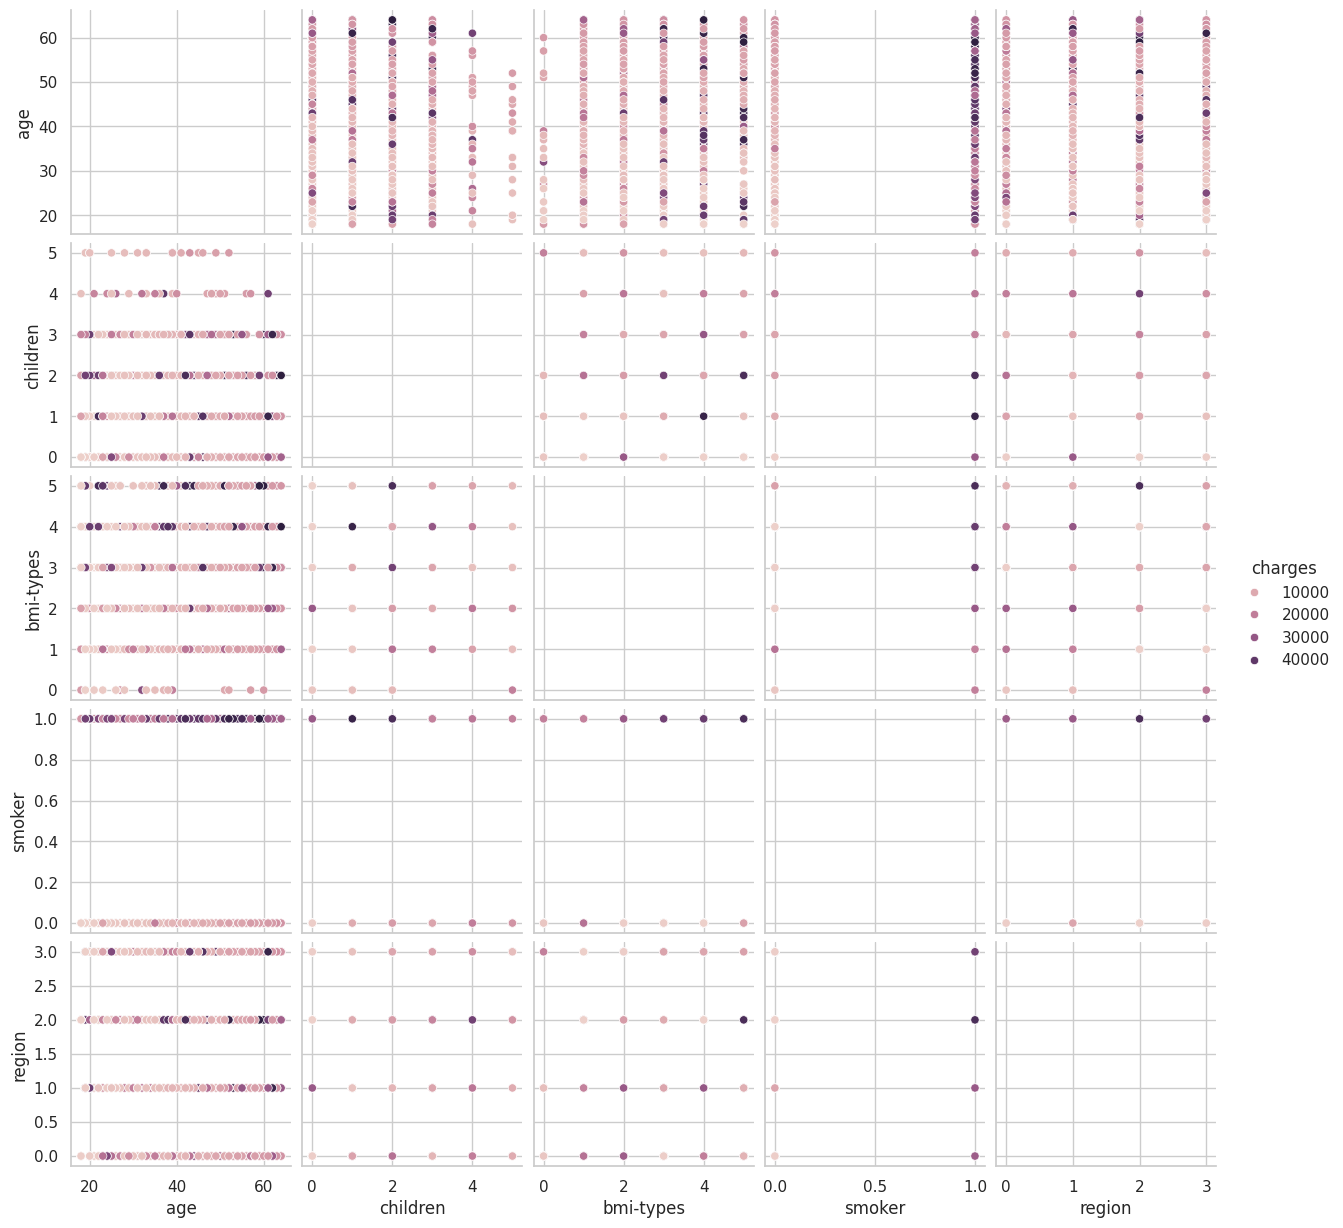

In [ ]:
sb.pairplot(dados,vars=[COL_AGE, COL_CHILDREN, COL_BMI_TYPES, COL_SMOKER,COL_REGION],hue=COL_CHARGES)


**3.2 - Correlações**

<Axes: >

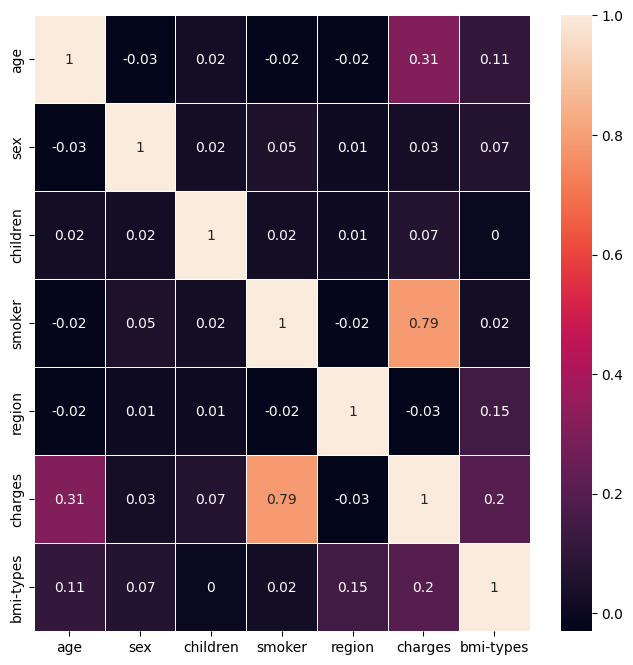

In [ ]:
dados_corr = dados.drop(columns=[COL_BMI])
correlation_matrix = dados_corr.corr().round(2)
fig, ax = plt.subplots(figsize=(8,8))
sb.heatmap(data=correlation_matrix, annot=True, linewidths=.5, ax=ax)

**obs:** pode ser percebido que a correlação dos gastos com a pessoa fumante é alta de **0,79** e com 'bmi' de **0,17** e de idade **0,31**


In [ ]:
dados_corr = dados.drop(columns=[COL_BMI_TYPES])
correlation_matrix = dados_corr.corr()
max_corr = correlation_matrix.stack().sort_values(ascending=False).drop_duplicates()
max_corr = max_corr[max_corr < 1].head(10)

print("Maiores correlações:")
print(max_corr)

Maiores correlações:
smoker    charges     0.785604
charges   age         0.303853
bmi       charges     0.187123
region    bmi         0.158168
bmi       age         0.108408
children  charges     0.076377
smoker    sex         0.076195
charges   sex         0.058287
sex       bmi         0.048938
age       children    0.042260
dtype: float64


# 4 - Modelos de Regressão



- **LinearRegression**: Este modelo ajusta uma linha reta aos dados, buscando a melhor combinação linear das variáveis independentes para prever a variável target;


- **DecisionTreeRegressor**: Este modelo cria uma árvore de decisão que divide repetidamente os dados em subconjuntos baseados em condições sobre as variáveis, visando minimizar a diferença entre os valores previstos e reais;


- **RandomForestRegressor**: Este modelo combina múltiplas árvores de decisão (floresta) treinadas em diferentes subconjuntos dos dados e características, agregando suas previsões para melhorar a precisão e reduzir o risco de overfitting;


- **GradientBoostingRegressor**: Este modelo constrói sequencialmente árvores de decisão, onde cada nova árvore corrige os erros das árvores anteriores, acumulando melhorias para aumentar a precisão das previsões e reduzir o overfitting.


- **XGBRegressor**: Este modelo, parte do XGBoost, aplica a técnica de boosting para criar uma série de árvores de decisão, melhorando continuamente os resultados ao focar nos erros residuais das iterações anteriores, sendo altamente eficiente e escalável.

# 5 - Separando as bases em treino e teste



- Para treinar modelos de aprendizado de máquina, é importante separar os dados em treino e teste. Sempre a maior porcentagem da base é alocada na base de treino (aproximadamente 80%) e o restante na base de teste (aproximadamente 20%).

- O objetivo do código foi dividir os dados em subconjuntos de treino e teste de forma que a distribuição seja a mesma a proporção. A divisão é feita de modo a manter a distribuição pela variável categórica (COL_BMI_TYPES) consistente em ambos os subconjuntos. Isso é essencial para garantir que o modelo treinado seja representativo e tenha bom desempenho em dados não vistos.

In [ ]:
X, y = define_x_y()

shuffle_split = False
standard_scaler = False
min_max_scaler = False

X_train, y_train, X_test, y_test = process_train_test(X, y, shuffle_split, standard_scaler, min_max_scaler)

# 6 - LinearRegression

**Run model**

In [20]:
dados = pd.read_csv(DATABASE_NAME)

removed_duplicated = True
removed_outliers = False
upsampling = True
dados = process_database(dados, removed_duplicated, removed_outliers, upsampling)

X, y = define_x_y()

standard_scaler = False
min_max_scaler = False
shuffle_split = False
X_train, y_train, X_test, y_test = process_train_test(X, y, shuffle_split, standard_scaler, min_max_scaler)

#ratings = pd.DataFrame();

model, y_pred, ratings = model_run("linear_regression", ratings)

ratings.head(40)

Número de registros duplicados: 1435
(2772, 7)
removendo dados duplicados...
(1337, 7)
run_upsampling
(5000, 7)
encoded_labels: ['sex', 'smoker', 'region']
categorizando a coluna bmi -> bmi-types
ShuffleSplit bmi-types: False StandardScaler: False MinMaxScaler: False
Avaliando o desempenho do modelo: LinearRegression - r2-score: 0.7720632481838658


,model,remove_duplicated,remove_outliers,upsampling,shuffle_bmi,std_scaler,min_max_scaler,k-fold std,k-fold mean,mae,mse,rmse,mape,r2-score
0,LinearRegression,True,False,False,False,False,False,0.042376,0.742420,4221.20,35762069.60,5980.14,43.24,0.8054
1,LinearRegression,True,False,True,False,False,False,0.026421,0.751505,4010.89,32851073.37,5731.59,40.56,0.7721


**Visualizando previsões**

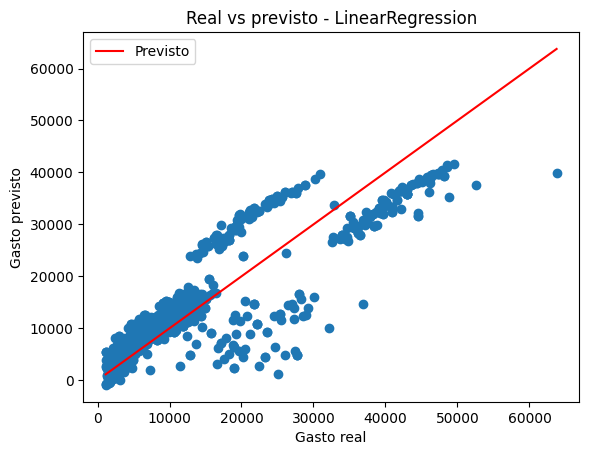

In [21]:
plt_real_previsto(y_test, y_pred, model)

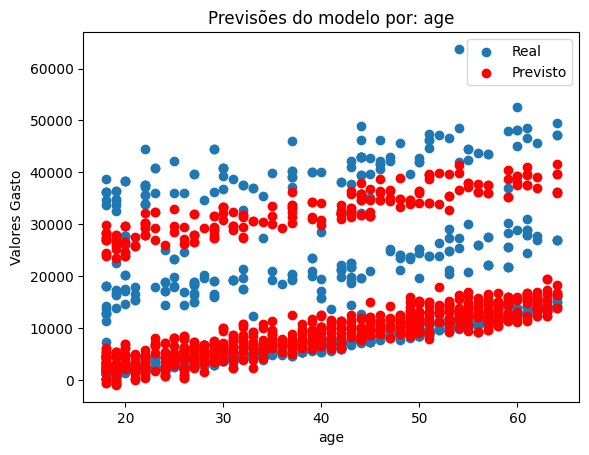

In [22]:
plt_real_previso_por(X_test, y_test, y_pred, COL_AGE)

# 7 - DecisionTreeRegressor



**Run model**

In [27]:
dados = pd.read_csv(DATABASE_NAME)

#ratings = pd.DataFrame();

removed_duplicated = True
removed_outliers = False
upsampling = True
dados = process_database(dados, removed_duplicated, removed_outliers, upsampling)

X, y = define_x_y()

standard_scaler = False
min_max_scaler = False
shuffle_split = False
X_train, y_train, X_test, y_test = process_train_test(X, y, shuffle_split, standard_scaler, min_max_scaler)

model, y_pred, ratings = model_run("decision_tree_regressor", ratings)

ratings.head(40)

Número de registros duplicados: 1435
(2772, 7)
removendo dados duplicados...
(1337, 7)
run_upsampling
(5000, 7)
encoded_labels: ['sex', 'smoker', 'region']
categorizando a coluna bmi -> bmi-types
ShuffleSplit bmi-types: False StandardScaler: False MinMaxScaler: False
Avaliando o desempenho do modelo: DecisionTreeRegressor - r2-score: 0.9789886215624491


,model,remove_duplicated,remove_outliers,upsampling,shuffle_bmi,std_scaler,min_max_scaler,k-fold std,k-fold mean,mae,mse,rmse,mape,r2-score
0,DecisionTreeRegressor,True,False,False,False,False,False,0.063616,0.711690,2909.51,39549960.77,6288.88,40.73,0.7848
1,DecisionTreeRegressor,True,False,True,False,False,False,0.007092,0.988403,199.78,3028236.25,1740.18,1.92,0.9790


**Visualizando as previsões**

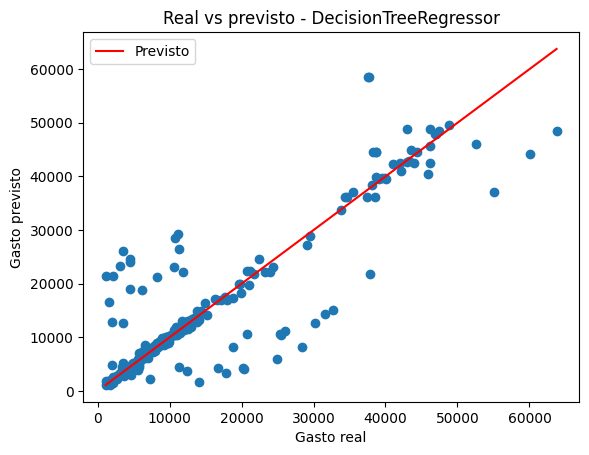

In [ ]:
plt_real_previsto(y_test, y_pred, model)

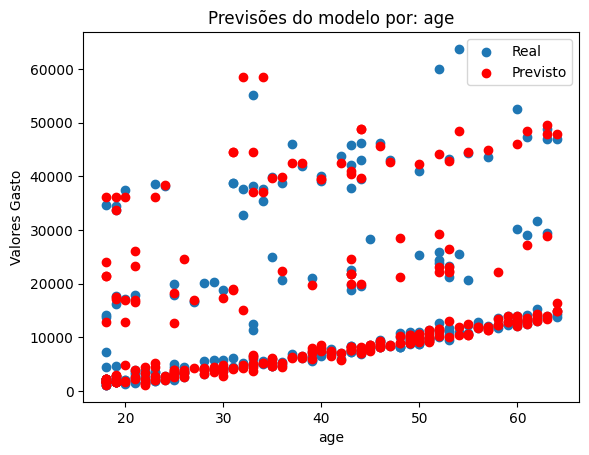

In [ ]:
plt_real_previso_por(X_test, y_test, y_pred, COL_AGE)

# 8 - RandomForestRegressor

**Run model**

In [36]:
dados = pd.read_csv(DATABASE_NAME)

removed_duplicated = True
removed_outliers = False
upsampling = False
dados = process_database(dados, removed_duplicated, removed_outliers, upsampling)

X, y = define_x_y()

standard_scaler = False
min_max_scaler = False
shuffle_split = False
X_train, y_train, X_test, y_test = process_train_test(X, y, shuffle_split, standard_scaler, min_max_scaler)

#ratings = pd.DataFrame();

model, y_pred, ratings = model_run(RANDOM_FOREST_REGRESSOR_NAME, ratings)

ratings.head(40)

Número de registros duplicados: 1435
(2772, 7)
removendo dados duplicados...
(1337, 7)
encoded_labels: ['sex', 'smoker', 'region']
categorizando a coluna bmi -> bmi-types
ShuffleSplit bmi-types: False StandardScaler: False MinMaxScaler: False
Avaliando o desempenho do modelo: RandomForestRegressor - r2-score: 0.9047009136989721


,model,remove_duplicated,remove_outliers,upsampling,shuffle_bmi,std_scaler,min_max_scaler,k-fold std,k-fold mean,mae,mse,rmse,mape,r2-score
0,RandomForestRegressor,True,False,True,False,False,False,0.019802,0.880517,2220.17,15677466.02,3959.48,25.39,0.8912
1,RandomForestRegressor,True,False,True,True,False,False,0.019802,0.880517,2322.02,18318615.43,4280.03,24.22,0.8730
2,RandomForestRegressor,True,False,False,False,False,False,0.028706,0.859449,2390.01,17511785.01,4184.71,28.62,0.9047
3,RandomForestRegressor,True,False,False,False,True,False,0.028706,0.859449,2390.65,17506815.71,4184.11,28.64,0.9047
4,RandomForestRegressor,True,False,False,False,False,True,0.028706,0.859449,2390.13,17512762.15,4184.83,28.62,0.9047
5,RandomForestRegressor,True,False,False,True,False,False,0.028706,0.859449,2660.54,22908810.23,4786.31,29.89,0.8642
6,RandomForestRegressor,True,False,False,False,True,False,0.028706,0.859449,2390.65,17506815.71,4184.11,28.64,0.9047
7,RandomForestRegressor,True,False,False,False,False,False,0.028706,0.859449,2390.01,17511785.01,4184.71,28.62,0.9047


**Vizualizando as previsões**

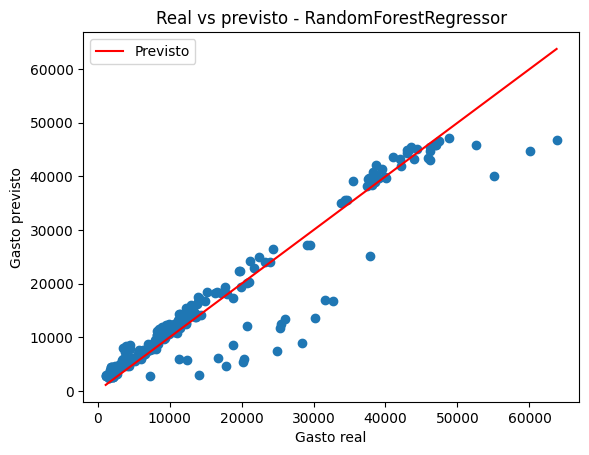

In [37]:
plt_real_previsto(y_test, y_pred, model)

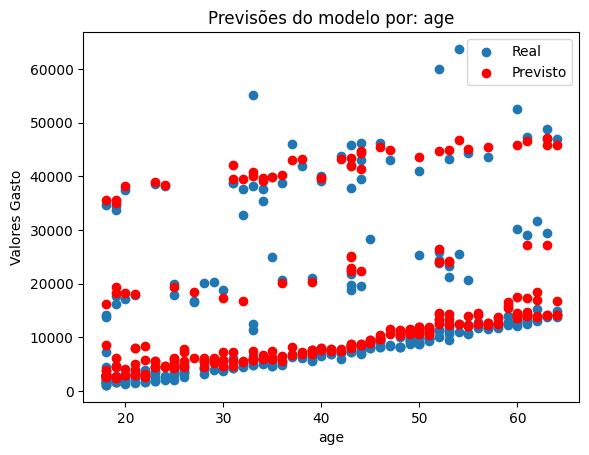

In [38]:
plt_real_previso_por(X_test, y_test, y_pred, COL_AGE)

# 9 - GradientBoostingRegressor

- **run model**

In [ ]:
dados = pd.read_csv(DATABASE_NAME)

removed_duplicated = True
removed_outliers = False
upsampling = False
dados = process_database(dados, removed_duplicated, removed_outliers, upsampling)

X, y = define_x_y()

standard_scaler = False # não melhora
min_max_scaler = False
shuffle_split = False
X_train, y_train, X_test, y_test = process_train_test(X, y, shuffle_split, standard_scaler, min_max_scaler)

#ratings = pd.DataFrame();

model, y_pred, ratings = model_run("gradient_boosting_regressor", ratings)

ratings.head(40)

Número de registros duplicados: 1435
(2772, 7)
removendo dados duplicados...
(1337, 7)
encoded_labels: ['sex', 'smoker', 'region']
categorizando a coluna bmi -> bmi-types
ShuffleSplit bmi-types: False StandardScaler: False MinMaxScaler: False
Avaliando o desempenho do modelo: GradientBoostingRegressor - r2-score: 0.8874170924794242


,model,remove_duplicated,remove_outliers,upsampling,shuffle_bmi,std_scaler,min_max_scaler,k-fold std,k-fold mean,mae,mse,rmse,mape,r2-score
0,GradientBoostingRegressor,True,False,False,False,False,False,0.030836,0.857525,2613.50,18655153.07,4319.16,32.86,0.8985
1,GradientBoostingRegressor,True,False,False,False,False,False,0.029903,0.855466,2543.63,18467740.69,4297.41,34.38,0.8995
2,GradientBoostingRegressor,True,False,False,False,False,False,0.033052,0.845165,2814.81,20687791.96,4548.38,37.51,0.8874


# 10 - Executando todos os modelos

**Inicializando e processando a base dados**

In [ ]:
dados = pd.read_csv(DATABASE_NAME)

removed_duplicated = True
removed_outliers = False
upsampling = False

dados = process_database(dados, removed_duplicated, removed_outliers, upsampling)

ratings = pd.DataFrame();

Número de registros duplicados: 1435
(2772, 7)
removendo dados duplicados...
(1337, 7)
encoded_labels: ['sex', 'smoker', 'region']
categorizando a coluna bmi -> bmi-types


**Run modelos**

In [ ]:
ratings = pd.DataFrame();

X, y = define_x_y()

shuffle_split = False
standard_scaler = False
min_max_scaler = False

X_train, y_train, X_test, y_test = process_train_test(X, y, shuffle_split, standard_scaler, min_max_scaler)

for mod in models:
    model, y_pred, ratings = model_run(mod, ratings)

print("\nResultado: Ordenado pelo melhor r2-score")
ratings.sort_values(by='r2-score', ascending=False)

ShuffleSplit bmi-types: False
StandardScaler: False
Avaliando o desempenho do modelo: LinearRegression - r2-score: 0.8053829146335082
Avaliando o desempenho do modelo: DecisionTreeRegressor - r2-score: 0.7847692212422388
Avaliando o desempenho do modelo: RandomForestRegressor - r2-score: 0.9047009136989721
Avaliando o desempenho do modelo: GradientBoostingRegressor - r2-score: 0.8874170924794242
Avaliando o desempenho do modelo: XGBRegressor - r2-score: 0.865363626954129
Avaliando o desempenho do modelo: Lasso - r2-score: 0.8053529762914795
Avaliando o desempenho do modelo: Ridge - r2-score: 0.804449915037567

Resultado: Ordenado pelo melhor r2-score


,model,remove_duplicated,remove_outliers,upsampling,shuffle_bmi,std_scaler,min_max_scaler,k-fold std,k-fold mean,mae,mse,rmse,mape,r2-score
2,RandomForestRegressor,True,False,False,False,False,False,0.028706,0.859449,2390.01,17511785.01,4184.71,28.62,0.9047
3,GradientBoostingRegressor,True,False,False,False,False,False,0.033052,0.845165,2814.81,20687791.96,4548.38,37.51,0.8874
4,XGBRegressor,True,False,False,False,False,False,0.036100,0.807401,2874.82,24740249.99,4973.96,41.33,0.8654
0,LinearRegression,True,False,False,False,False,False,0.042376,0.742420,4221.20,35762069.60,5980.14,43.24,0.8054
5,Lasso,True,False,False,False,False,False,0.042366,0.742426,4221.59,35767570.95,5980.60,43.24,0.8054
6,Ridge,True,False,False,False,False,False,0.041906,0.742503,4236.37,35933513.94,5994.46,43.45,0.8044
1,DecisionTreeRegressor,True,False,False,False,False,False,0.063616,0.711690,2909.51,39549960.77,6288.88,40.73,0.7848


In [ ]:
print("Resultado: Ordenado pelo melhor r2")
#ratings.sort_values(by='r2-score', ascending=False)
ratings

**Desempenho do modelo de regressão:**

**- Mean Absolute Error (mae):**

mede a média das diferenças absolutas entre as previsões do modelo e os valores reais. Em termos simples, o MAE nos diz quão distantes, em média, as previsões estão dos valores reais. Quanto menor o valor do MAE, mais precisas são as previsões do modelo. É uma medida direta da qualidade das previsões, sem levar em conta a direção dos erros.

**- Mean Squared Error (mse):**

Em vez de calcular a média das diferenças absolutas entre previsões e valores reais, o MSE calcula a média dos quadrados dessas diferenças. Isso significa que o MSE penaliza erros grandes de forma mais significativa do que erros menores. Assim como o MAE, quanto menor o valor do MSE, melhor o desempenho do modelo. No entanto, como os erros são elevados ao quadrado, o MSE tende a ser mais sensível a valores extremos do que o MAE.

**- Erro Quadrático Médio da Raiz (rmse):**

 é uma versão do MSE que leva em conta a raiz quadrada dos erros quadráticos médios. Em essência, o RMSE é uma medida da dispersão dos erros entre as previsões e os valores reais. Como o MSE, o RMSE também penaliza erros grandes, mas devido à raiz quadrada, sua unidade é a mesma dos dados originais, o que facilita a interpretação. Assim como o MSE, quanto menor o valor do RMSE, melhor o desempenho do modelo de regressão.

**- Mean Absolute Percentage Error (mape):**

 é uma métrica usada para avaliar a precisão de previsões em relação aos valores reais, expressando o erro médio como uma porcentagem do valor real. Ele calcula a média das diferenças percentuais absolutas entre as previsões e os valores reais.

**- R² Score (r2-score):**

é uma métrica que nos ajuda a entender o quanto as variações nas variáveis independentes explicam as variações na variável que estamos tentando prever (variável dependente) em um modelo de regressão. Quanto mais próximo de 1, melhor o modelo está em explicar a variabilidade dos dados. No entanto, é importante observar que o R² Score não indica a qualidade absoluta do modelo, mas sim a adequação do modelo em relação aos dados utilizados.

# 11 - Verificação de overfitting e hiperparâmetros

In [ ]:
def random_forest_regressor():
  model = RandomForestRegressor(random_state=42)
  #model = RandomForestRegressor(max_depth = 5, max_features = 'auto', n_estimators = 180, min_samples_leaf = 10, min_samples_split =5, random_state = 42)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  return model, y_pred

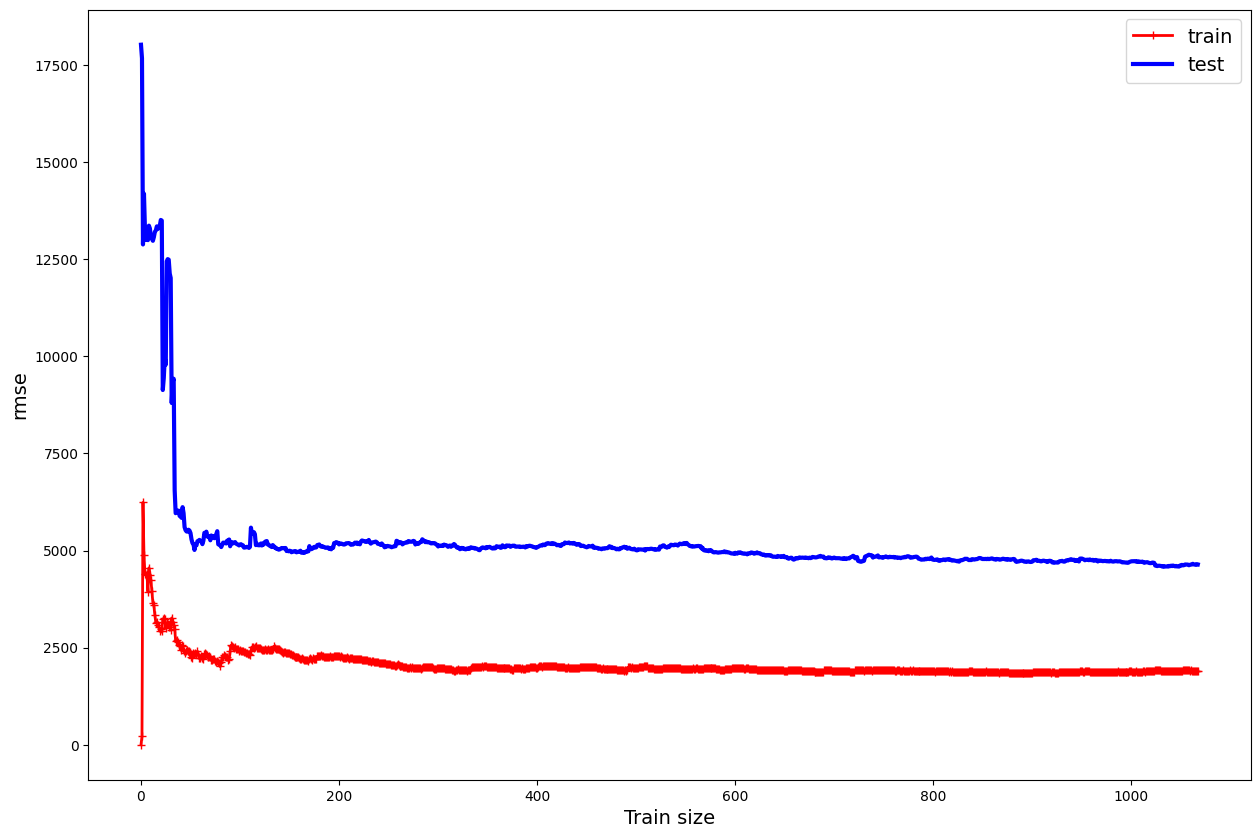

In [ ]:
plt.figure(figsize = (15, 10))
plot_learning_curves(model, X_train, X_test, y_train, y_test)

**É overfitting.** A razão é que o conjunto de teste **X_test** tem valores de **RMSE** muito mais altos do que o conjunto de treinamento **X_train**.

- Para verificar o melhor hiperparâmetro de depth

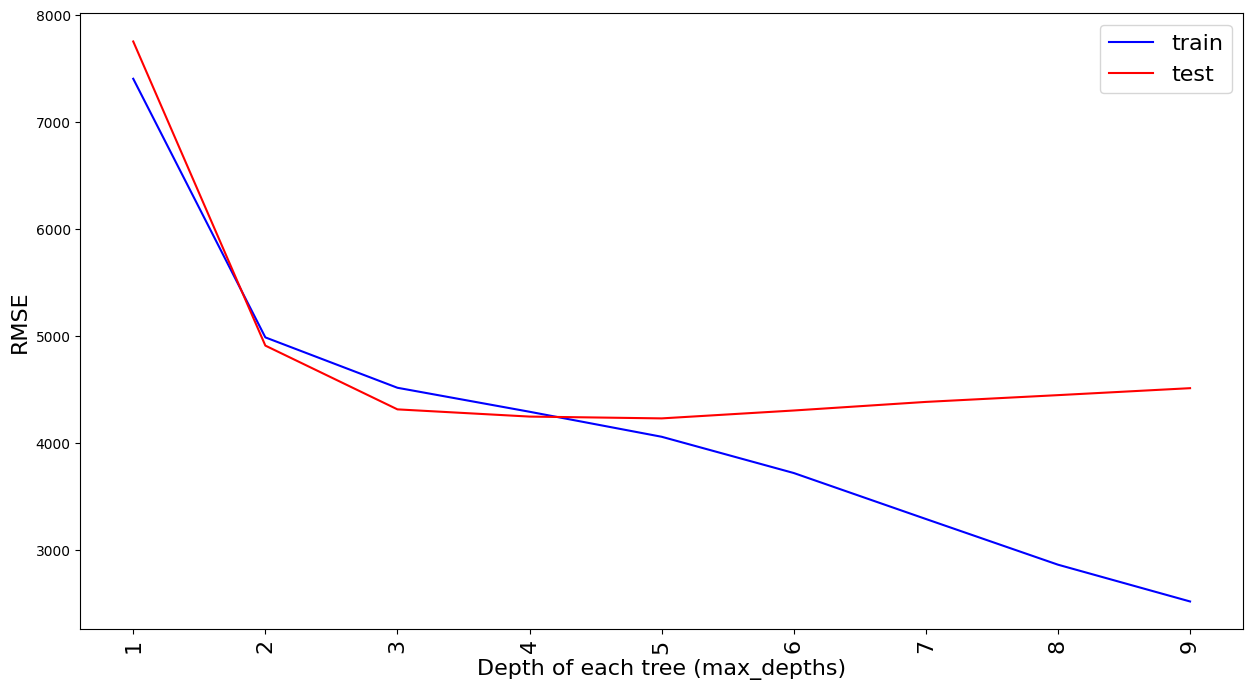

In [ ]:
max_depths = np.arange(1, 10, 1)
param_range = max_depths

train_results = []; test_results = []
for max_depth in max_depths:
   # model = GradientBoostingRegressor(max_depth = max_depth, random_state = 42)
    model = RandomForestRegressor(max_depth = max_depth, random_state = 42)
    model.fit(X_train, y_train)

    train_pred = model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    train_results.append(train_rmse)

    test_pred = model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    test_results.append(test_rmse)

plt.figure(figsize = (15, 8))
plt.plot(param_range, train_results, 'b-', label = "train")
plt.plot(param_range, test_results, 'r-', label = "test")
plt.legend(loc = 'upper right', fontsize = 16)
plt.xticks(param_range, rotation = 90, fontsize = 16)
plt.ylabel("rmse", fontsize = 16)
plt.xlabel("Depth of each tree (max_depths)", fontsize = 16)
plt.show()

O melhor depth é 4

Para verificar o melhor hiperparâmetro de número de estimators

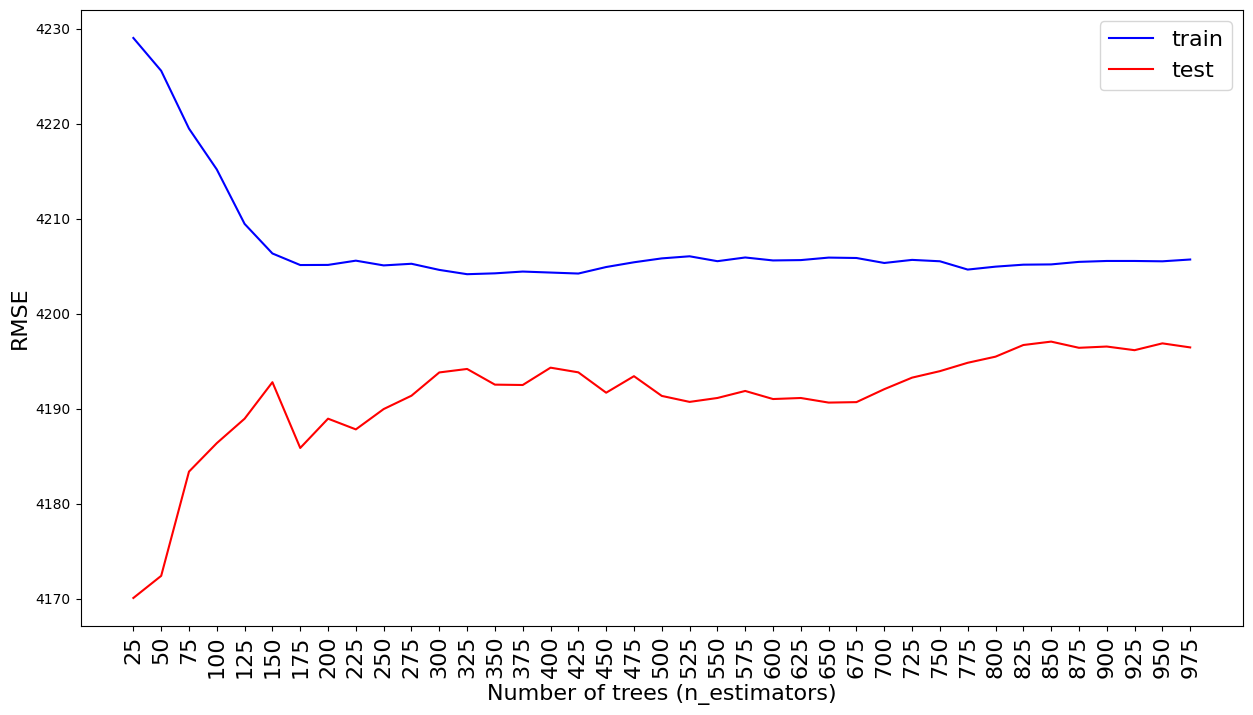

In [ ]:
n_estimators = np.arange(25, 1000, 25)
param_range = n_estimators

train_results = []; test_results = []
for n_estimator in n_estimators:

    model = RandomForestRegressor(max_depth = 5, max_features = 'auto', n_estimators = n_estimator, min_samples_leaf = 10, min_samples_split =5, random_state = 42)
    #model = GradientBoostingRegressor(max_depth = 2, n_estimators = n_estimator, random_state = 42)
    #model = GradientBoostingRegressor(n_estimators=n_estimator, random_state=42, max_depth=2, max_features= 'auto', min_samples_leaf=7, min_samples_split=7, learning_rate = 0.07, subsample = 0.3)
    model.fit(X_train, y_train)

    train_pred = model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    train_results.append(train_rmse)

    test_pred = model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    test_results.append(test_rmse)

plt.figure(figsize = (15, 8))
plt.plot(param_range, train_results, 'b-', label = "train")
plt.plot(param_range, test_results, 'r-', label = "test")
plt.legend(loc = 'upper right', fontsize = 16)
plt.xticks(param_range, rotation = 90, fontsize = 16)
plt.ylabel("rme", fontsize = 16)
plt.xlabel("Number of trees (n_estimators)", fontsize = 16)
plt.show()

n_estimator = 850

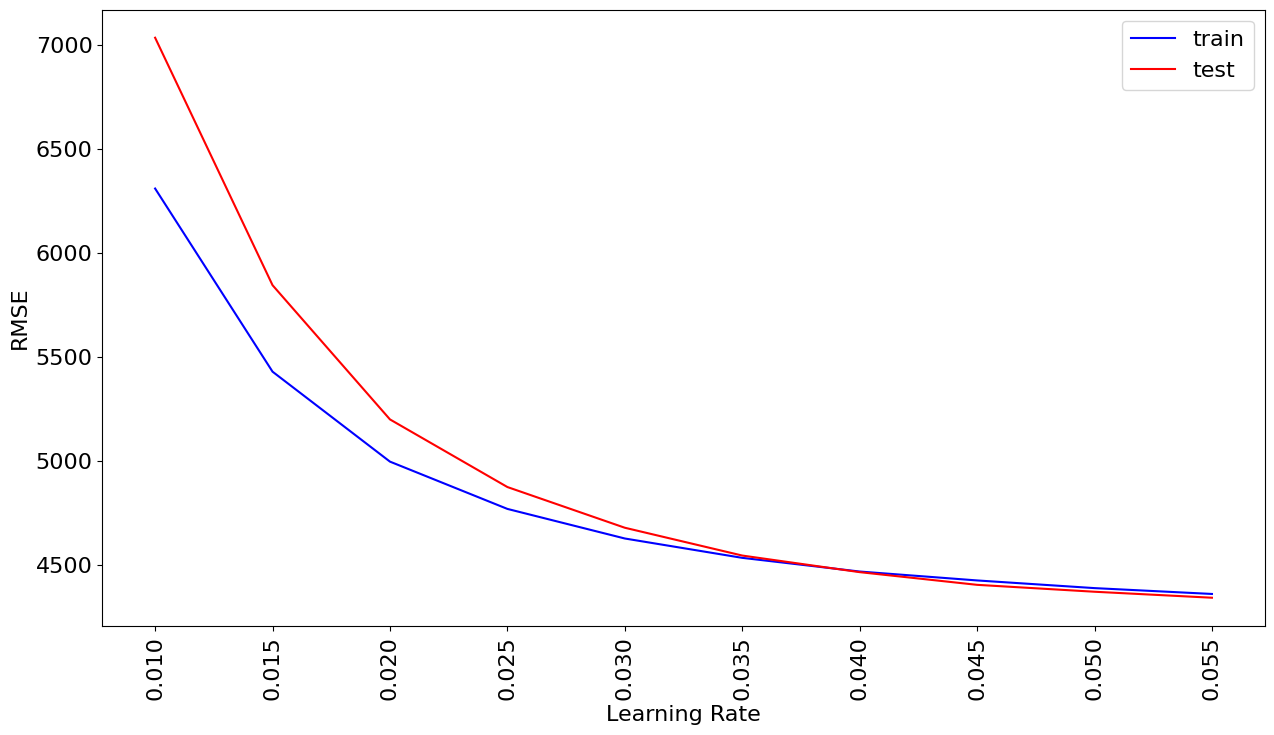

In [ ]:
learning_rates = np.arange(0.01, 0.06, 0.005)

train_results = []; test_results = []
for eta in learning_rates:
    model = GradientBoostingRegressor(max_depth = 2,learning_rate = eta, random_state = 42)
    model.fit(X_train, y_train)

    train_pred = model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    train_results.append(train_rmse)

    test_pred = model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    test_results.append(test_rmse)

plt.figure(figsize = (15, 8))
plt.plot(learning_rates, train_results, 'b-', label = "train")
plt.plot(learning_rates, test_results, 'r-', label = "test")
plt.legend(loc = 'upper right', fontsize = 16)
plt.xticks(learning_rates, rotation = 90, fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylabel("RMSE", fontsize = 16)
plt.xlabel("Learning Rate", fontsize = 16)
plt.show()

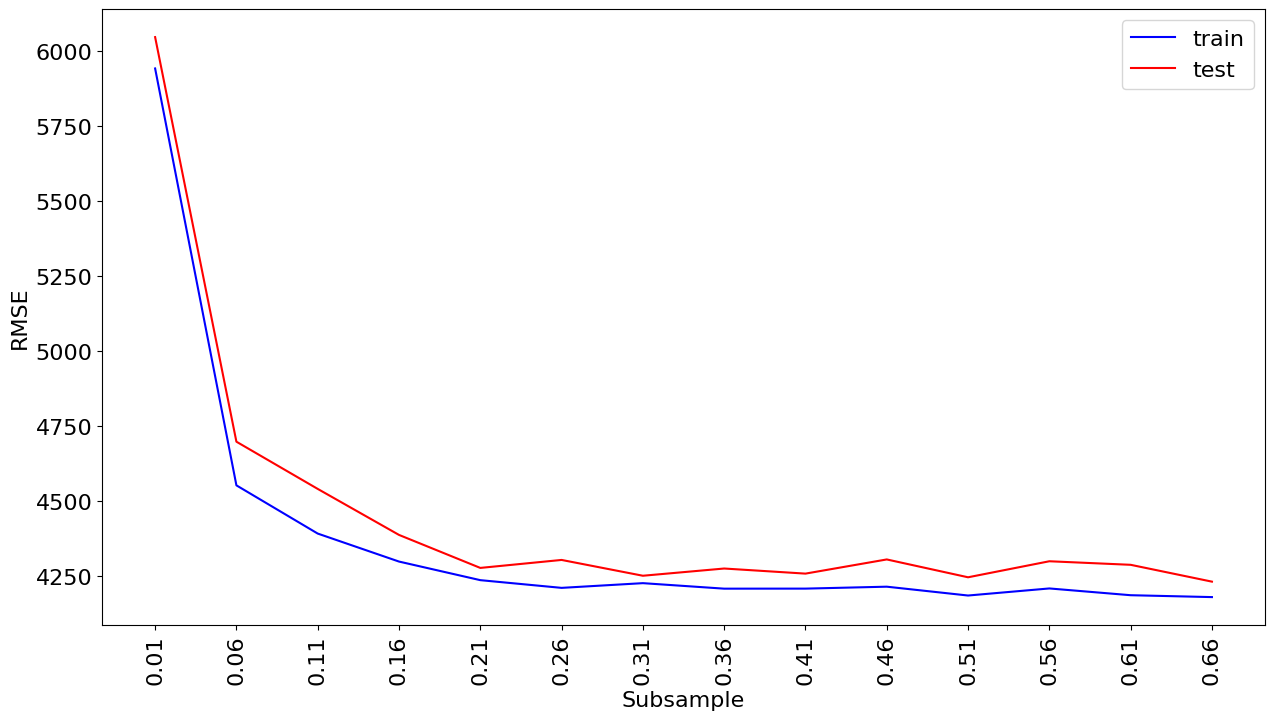

In [ ]:
subsamples = np.arange(0.01, 0.7, 0.05)
param_range = subsamples

train_results = []; test_results = []
for subsample in subsamples:
    model = GradientBoostingRegressor(max_depth = 2,subsample = subsample, random_state = 42)
    #model = GradientBoostingRegressor(n_estimators=n_estimator, random_state=42, max_depth=2, max_features= 'auto', min_samples_leaf=7, min_samples_split=7, learning_rate = 0.07, subsample = subsample)


    model.fit(X_train, y_train)

    train_pred = model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    train_results.append(train_rmse)

    test_pred = model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    test_results.append(test_rmse)

plt.figure(figsize = (15, 8))
plt.plot(param_range, train_results, 'b-', label = "train")
plt.plot(param_range, test_results, 'r-', label = "test")
plt.legend(loc = 'upper right', fontsize = 16)
plt.xticks(param_range, rotation = 90, fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylabel("RMSE", fontsize = 16)
plt.xlabel("Subsample", fontsize = 16)
plt.show()

- Após ajustes dos hiperparâmetros

In [ ]:

def gradient_boosting_regressor():
  #model = GradientBoostingRegressor(n_estimators=88, random_state=42,  learning_rate = 0.04, subsample = 0.06)
  model = GradientBoostingRegressor(n_estimators=88, random_state=42, max_depth=2, max_features= 'auto', min_samples_leaf=7, min_samples_split=7, learning_rate = 0.07, subsample = 0.3)
#  model = GradientBoostingRegressor(random_state=42)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  return model, y_pred

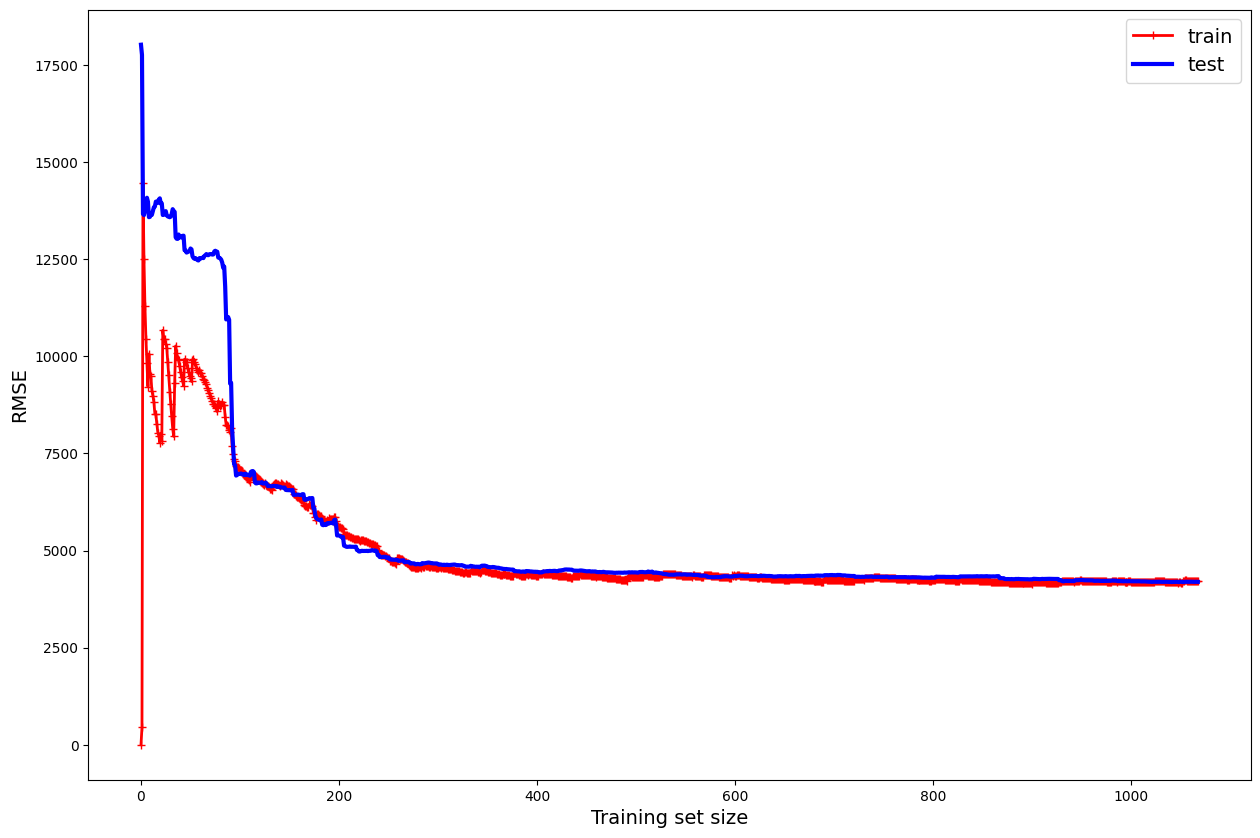

In [ ]:
plt.figure(figsize = (15, 10))
plot_learning_curves(model, X_train, X_test, y_train, y_test)

In [ ]:
gbr = GradientBoostingRegressor()

# Definindo a grade de hiperparâmetros
param_grid = {
    'n_estimators': [ 88],
    'learning_rate': [0.05, 0.06, 0.07],
    'max_depth': [2],
    'min_samples_split': [7, 8, 9],
    'min_samples_leaf': [5, 6, 7],
    'subsample': [0.30, 0.31, 0.32],
    'max_features': ['auto']
}

# Configurando o GridSearchCV
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Ajustando o modelo aos dados
grid_search.fit(X_train, y_train)

# Imprimindo os melhores hiperparâmetros
print("Melhores hiperparâmetros encontrados:")
print(grid_search.best_params_)

Melhores hiperparâmetros encontrados:
{'learning_rate': 0.07, 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 7, 'min_samples_split': 7, 'n_estimators': 88, 'subsample': 0.3}


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Definindo o modelo
rf = RandomForestRegressor()

# Definindo a grade de hiperparâmetros
param_grid = {
    'n_estimators': [220, 250, 300],
    'max_depth': [5],
    'min_samples_split': [ 5,10,15],
    'min_samples_leaf': [19,10,12],
    'max_features': ['auto'],
    'bootstrap': [True]
}

# Configurando o GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Ajustando o modelo aos dados
grid_search.fit(X_train, y_train)

# Imprimindo os melhores hiperparâmetros
print("Melhores hiperparâmetros encontrados:")
print(grid_search.best_params_)


Melhores hiperparâmetros encontrados:
{'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 10, 'min_samples_split': 15, 'n_estimators': 300}


# 12 - Resultados e conclusões



Conforme observado na análise dos dados, as características mais importantes que influenciam o aumento dos gastos com saúde são o tabagismo, o índice de massa corporal elevado e o avanço da idade.


Testamos vários modelos de regressão em diferentes cenários e, após análises decidimos:
- Remover os registros **duplicados**;
- NÃO remover os **outliers** (pelo cenário do negócio é uma situação que poder ocorrer, de ter alguns casos com gastos altos);
- NÃO usar a técnica de **Upsampling** (melhora o score vai para '0,98', mas como duplica os registros parece ficar muito enviezado);
- NÃO usar as técnicas de **Stander Scaler** e **MaxMin Scaler** (ambas não tiverem efeito)
- Não usar a técnica de **Split Shuffle** (teve queda no score).


Com o cenário acima obtivemos os seguintes resultados, ordenado pelo melhor **r2-score**:
- Gradient Boosting Regressor **(0,89)**;
- Random Forest Regressor **(0,88)**;
- XGB Regression (0,86);
- Linear Regression (0,80);
- Lasso (0,80);
- Ridge (0,80);
- Decision Tree Regressor (0,78),


Os modelos que obtiveram os melhores R² scores foram o **Random Forest** e o **Gradient Boosting**. A partir disso, ajustamos os hiperparâmetros desses modelos para melhorar um pouco mais o desempenho. Os resultados foram os seguintes:

- Random Forest Regressor **(0,9047)**;
- Gradient Boosting Regressor (0,8995).


Modelo escolhido é o **Random Forest Regressor**